In [1]:
from gensim import corpora, models, similarities
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from matplotlib import pyplot as plt
import logging, gensim
import pickle
from sklearn import metrics

import time
import urllib2
from bs4 import BeautifulSoup
import itertools
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier 
from sklearn.cross_validation import StratifiedKFold,cross_val_score
from sklearn.grid_search import GridSearchCV
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

import psycopg2
import pandas as pd
import numpy as np
import sqlalchemy as sa
from sqlalchemy_utils import database_exists, create_database
%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8  # plotsize
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'
plt.rcParams['font.size'] = 14

def text_cleaner(html): # return a single line of cleaned text
    '''
    This function just cleans up the raw html.
    Inputs: a URL to investigate
    Outputs: Cleaned text only after parsing, tokenization, lemmerization, remove stop-words
    '''
    try:
        site = urllib2.urlopen(html).read() # Connect to the job posting
    except:
        print "Error loading " + html
        return   # Need this in case the website isn't there anymore or some other weird connection problem 

    soup_obj = BeautifulSoup(site,"lxml") # Get the html from the site

    for script in soup_obj(["script", "style"]):
        script.extract() # Remove these two elements from the BS4 object
    
    text = soup_obj.body.get_text('\n') # Get the text from this

    lines = (line.strip() for line in text.splitlines()) # break into lines
#    lines = [line for i, line in enumerate(lines) if i>16]
#    for line in lines:
#        print line
    chunks = (phrase.strip() for line in lines for phrase in line.split("  ")) # break multi-headlines into a line each
    
    def chunk_space(chunk):
        chunk_out = chunk + ' ' # Need to fix spacing issue
        return chunk_out  

    text = ''.join(chunk_space(chunk) for chunk in chunks if chunk).encode('utf-8') # Get rid of all blank lines and ends of line

    # Now clean out all of the unicode junk (this line works great!!!)
    try:
        text = text.decode('unicode_escape').encode('ascii', 'ignore') # Need this as some websites aren't formatted
    except:                                                            # in a way that this works, can occasionally throw
        return                                                         # an exception

    text = re.sub("[^a-zA-Z+3]"," ", text)  # Now get rid of any terms that aren't words (include 3 for d3.js)
                                                # Also include + for C++
        
    # remove the junk from the beginning and end parts of Indeed
    try:
        text = ((text.lower()).split('advanced search')[1]).split('save resume')[0]
    except:
        return text
    
    return text

def Preprocessing_line(line): # perform tokenization, select noun, Lemmertization etc on a line text
    rtext=[]    
    for w, tag in nltk.pos_tag(nltk.word_tokenize(line.lower())):  # Tokenization
        if tag in ['NN']:  # Keep only Nouns (for this special case)
            rtext.append(w)
    
    wordnet_lemmatizer = WordNetLemmatizer()  # Lemmertization
    rtext = [wordnet_lemmatizer.lemmatize(w) for w in rtext]
            
    stop_words = set(stopwords.words("english")) # Filter out any stop words
    rtext = [w for w in rtext if not w in stop_words]
    
    return rtext # return list of tokens

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


### V5: consider using the classification probability as the matching degree (different from V4)

In [2]:
def LSI_tfidf_model(dictionary, mm, tfidfmodel, num_topics=200):
    corpus_tfidf = tfidfmodel[mm]  # transform to tfidf space and then perform LSI
    
    lsimodel = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=num_topics) # initialize an LSI transformation
    lsimodel.show_topics(num_topics=10, num_words=20)
    lsimodel.print_topics(num_topics=5, num_words=10)
    
    corpus_lsi = lsimodel[corpus_tfidf] # doc-topic matrix in LSI space
    
    index = similarities.MatrixSimilarity(corpus_lsi) # transform corpus to LSI
    
    return lsimodel, corpus_lsi, index  # all in the tfidf space (instead of bag-of-words)

## Validation through text classification using document-topic matrix

### load the jobs table

In [3]:
path = '/home/hxzheng/Insight_DS_Fellowship/Project/JobRecomm/Resume_text/'

In [4]:
j=1
num_topics=100
jobs=pd.read_pickle(path + "jobs_table.dat") 
dictionary = gensim.corpora.Dictionary.load(path + 'dict'+str(j)+'.dict')
mm = gensim.corpora.MmCorpus(path + 'corpus'+str(j)+'.mm')
tfidfmodel = models.TfidfModel.load(path + 'tfidfmodel'+str(j)+'.tfidf')

lsimodel,corpus_lsi,index = LSI_tfidf_model(dictionary, mm, tfidfmodel, num_topics=num_topics)

In [5]:
### save index for later similarity queries

index.save(path + 'final_lsimodel.index')
lsimodel.save(path + 'final_lsimodel.lsi')

In [6]:
xtrain, ytrain = [], []
for i,doc_lsi in enumerate(corpus_lsi):
    if doc_lsi!=[]:                              # filter out empty documents
        xtrain.append([w[1] for w in doc_lsi])
        ytrain.append(jobs.ix[i]['jobid'])

xtrain = np.array(xtrain)
ytrain = np.array(ytrain)

In [7]:
np.unique(ytrain).shape

(4,)

In [8]:
ytrain.shape[0]

2816

In [9]:
RF = RandomForestClassifier(n_estimators = 500, n_jobs = -1,random_state =100, \
                                    max_features = "auto", min_samples_leaf = 1)
RF = RF.fit(xtrain,ytrain)

In [10]:
print RF.predict_proba(xtrain[0,:])

[[ 0.958  0.012  0.016  0.014]]


/home/hxzheng/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [11]:
### save the trained model

with open(path+'Final_RF_LSIMODEL.pkl', 'wb') as outfile:
    pickle.dump(RF, outfile, protocol =2)  
    
RF_Model=pd.read_pickle(path+'Final_RF_LSIMODEL.pkl')      

In [12]:
y_ex1=RF_Model.predict_proba(xtrain[0,:])
print y_ex1

[[ 0.958  0.012  0.016  0.014]]


/home/hxzheng/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [41]:
print RF.classes_
feature_rank = RF.feature_importances_
print feature_rank

[0 1 2 3]
[ 0.02079976  0.1634093   0.14488351  0.05587884  0.0331943   0.01879571
  0.0263448   0.01381791  0.02816849  0.00918089  0.01130591  0.00921043
  0.01364426  0.00756931  0.01170013  0.01306944  0.01028931  0.00714943
  0.00878518  0.00837256  0.00665952  0.00715278  0.00605817  0.0061368
  0.00864527  0.01000951  0.00546015  0.00515057  0.005052    0.00590262
  0.00606694  0.00604078  0.00565727  0.00474027  0.00565599  0.0044648
  0.00564315  0.00572807  0.00516846  0.00443554  0.00474184  0.00470421
  0.00568515  0.00490464  0.00565749  0.00476694  0.0054629   0.00418462
  0.00401752  0.00441879  0.00404806  0.00507735  0.00420125  0.00475698
  0.00461063  0.00402004  0.00464906  0.00472696  0.00460473  0.00502911
  0.0044981   0.00406455  0.00444142  0.00444587  0.00435792  0.00416808
  0.00441374  0.00445202  0.00404494  0.00457337  0.00434221  0.00408071
  0.00404521  0.00437078  0.0039918   0.00397225  0.00417522  0.00447856
  0.00413301  0.0043543   0.0042102   0.004

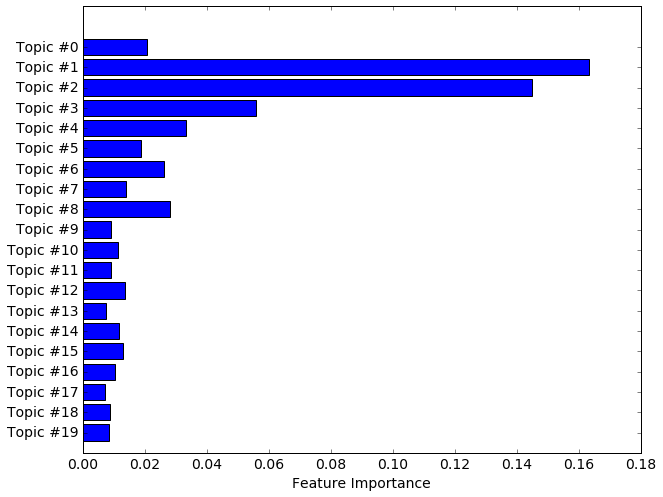

In [42]:
### Visualization of feature important
nkeep =20
feature_name = ['Topic #'+str(i) for i in xrange(len(feature_rank))]
y_pos = np.arange(len(feature_name))

feature_name = feature_name[:nkeep]
y_pos = y_pos[:nkeep]
feature_rank = feature_rank[:nkeep]

feature_name.reverse()  # reverse the order 
feature_rank = feature_rank[::-1]


plt.figure()
plt.barh(y_pos, feature_rank,  align='center', alpha=1.0,color='b')
plt.yticks(y_pos, feature_name)
plt.xlabel('Feature Importance')
plt.ylim(-1,21)
plt.savefig(path + 'Feature_Importance_RFClassifier.png', bbox_inches='tight')

In [32]:
TopTopics = lsimodel.show_topics(num_topics=10, num_words=50)

In [37]:
for i in range(1,5,1):
    print "The %dth top topic is:"%i
    print TopTopics[i]
    print '\n'

The 1th top topic is:
(1, u'0.373*"marketing" + 0.224*"strategy" + -0.197*"software" + -0.187*"application" + -0.163*"engineer" + 0.159*"brand" + 0.157*"market" + -0.153*"test" + -0.142*"java" + 0.130*"product" + -0.129*"server" + 0.128*"manager" + -0.123*"sql" + -0.116*"web" + 0.114*"revenue" + -0.106*"oracle" + 0.101*"growth" + -0.100*"system" + -0.096*"code" + -0.094*"developer" + -0.092*"javascript" + -0.090*"spring" + -0.089*"j" + -0.085*"framework" + -0.085*"design" + -0.081*"database" + -0.081*"jquery" + 0.079*"customer" + 0.078*"advertising" + -0.078*"html" + 0.075*"consumer" + 0.072*"pricing" + 0.071*"campaign" + -0.070*"environment" + 0.068*"program" + 0.068*"director" + -0.065*"c" + 0.064*"year" + -0.063*"mvc" + -0.062*"c++" + 0.061*"launch" + 0.061*"business" + -0.060*"ee" + -0.060*"cs" + -0.060*"net" + 0.060*"budget" + -0.056*"interface" + -0.055*"description" + 0.055*"leadership" + -0.055*"architecture"')


The 2th top topic is:
(2, u'0.239*"scientist" + -0.227*"marketing

### Example case

In [ ]:
html = 'http://www.indeed.com/r/Vadim-s/f365459c83af555d'
line = text_cleaner(html)
doc = Preprocessing_line(line)
vec_bow = dictionary.doc2bow(doc)
vec_lsi = lsimodel[tfidfmodel[vec_bow]] # convert the query to tfidf->LSI space
x_lsi = [weight for _,weight in vec_lsi]

ypred_proba=RF_Model.predict_proba(x_lsi)
print ypred_proba
print np.argmax(ypred_proba[0])